In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

%matplotlib inline
plt.style.use("ggplot")

In [2]:

def daily_returns(data : pd.Series) -> float:
    '''
        Function to calculate daily returns from daliy price data
    '''
    return data.pct_change()

def tracking_error(benchmark : pd.Series, portfolio : pd.Series) -> float:
    '''
        Function to compute tracking error
    '''
    return (portfolio - benchmark).std()

# Read Portfolios and trading Strategies

In [3]:
%run -i 'portfolio.py'

Building Portfolios and Initialising Trading Algorithms


AttributeError: module 'pandas' has no attribute 'DateTime'

In [ ]:
portfolio_tickers = ["SPY","ACWX","SCHO","BNDX","USO"]

ticker_set = dict()
for year in range(2010,2021):
    ticker_set[year] = portfolio_tickers
ticker_set

{2010: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2011: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2012: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2013: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2014: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2015: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2016: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2017: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2018: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2019: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO'],
 2020: ['SPY', 'ACWX', 'SCHO', 'BNDX', 'USO']}

# BenchMark Portfolio

Choosing the following ETFs for each asset class:
<table>
    <th>
        <td>Ticker</td>
        <td>Weight</td>
        <td>Ticker Description</td>
    </th>
    <tr>
        <td>US Market</td>
        <td><b>SPY</b></td>
        <td>30%</td>
        <td>S&P 500 ETF</td>
    </tr>
    <tr>
        <td>International Markets (ex. US)</td>
        <td><b>ACWX</b></td>
        <td>25%</td>
        <td>MSCI Asian/Emerging Markets ex U.S. ETF</td>
    </tr>
    <tr>
        <td>US Bonds</td>
        <td><b>SCHO</b></td>
        <td>20%</td>
        <td>Schwab Short Term US Treasury ETF</td>
    </tr>
    <tr>
        <td>International Bonds</td>
        <td><b>BNDX</b></td>
        <td>15%</td>
        <td>Vanguard Total International Bond Index Fund ETF Shares</td>
    </tr>
    <tr>
        <td>Other Asset Classes</td>
        <td><b>USO</b></td>
        <td>10%</td>
        <td>United States Oil Fund, LP</td>
    </tr>
</table>

In [ ]:
portfolio_tickers = ["SPY","ACWX","SCHO","BNDX","USO"]
stocks = yf.Tickers(" ".join(portfolio_tickers))

# weights = pd.Series([0.30, 0.25, 0.20, 0.15, 0.10], index= portfolio_tickers)
# weights

[*********************100%***********************]  5 of 5 completed


close                                                div       \
                 ACWX       BNDX       SCHO         SPY         USO ACWX BNDX   
Date                                                                            
2013-06-04  34.427258  42.735870  46.265118  139.147491  265.600006  0.0  0.0   
2013-06-05  33.852005  42.786823  46.255951  137.199280  266.079987  0.0  0.0   
2013-06-06  34.003811  42.727367  46.265118  138.441376  268.959991  0.0  0.0   
2013-06-07  34.291435  42.642391  46.255951  140.202347  273.279999  0.0  0.0   
2013-06-10  34.267467  42.336533  46.246780  140.202347  272.000000  0.0  0.0   

                          
           SCHO  SPY USO  
Date                      
2013-06-04  0.0  0.0   0  
2013-06-05  0.0  0.0   0  
2013-06-06  0.0  0.0   0  
2013-06-07  0.0  0.0   0  
2013-06-10  0.0  0.0   0

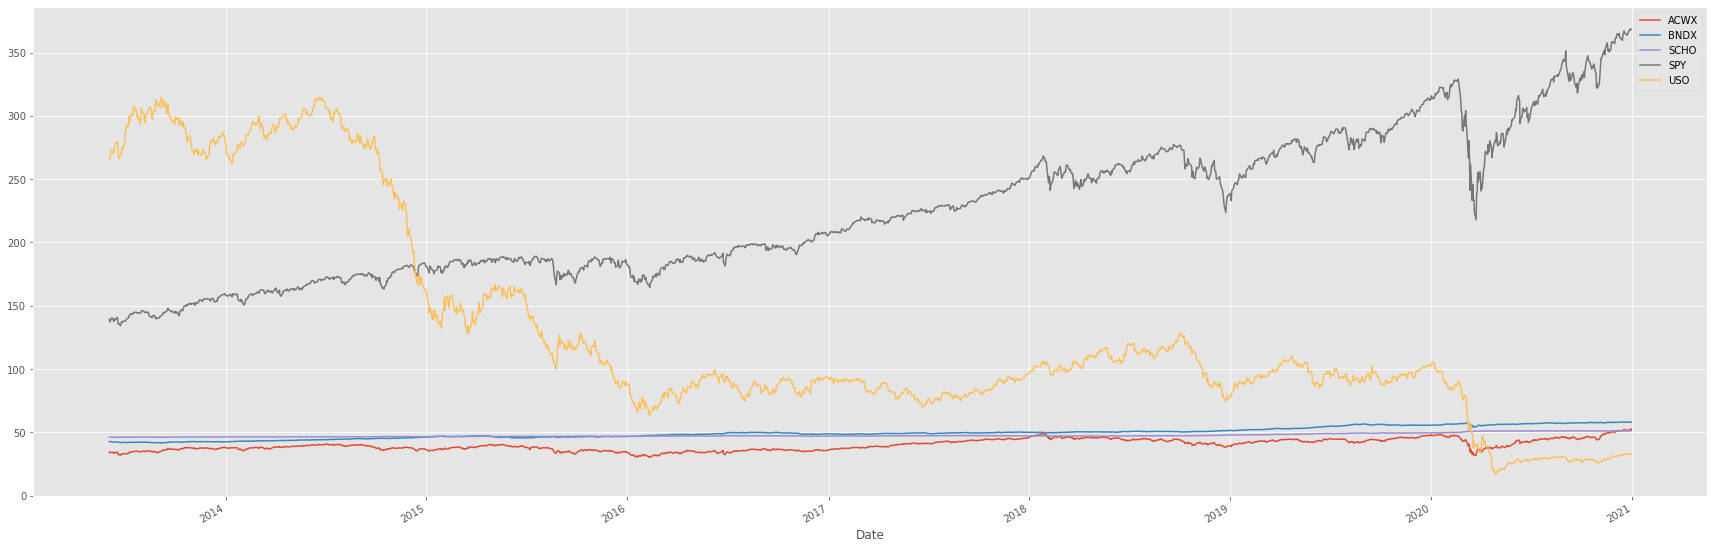

In [ ]:
stock_data = stocks.download(" ".join(portfolio_tickers), start="2010-01-01", end="2020-12-31")[["Close","Dividends"]].dropna()
stock_data.rename({"Close":"close","Dividends":"div"}, axis  =1, inplace= True)
stock_data["close"].plot(figsize = (30,10))
stock_data.head()
# stock_data["shares"] = stock_data.apply(lambda x: shares, axis = 1)

In [ ]:
for tic in portfolio_tickers:
    stock_data[("shares", tic)] = pd.Series([1]*len(stock_data.index), index= stock_data.index)
stock_data.head()

close                                                div       \
                 ACWX       BNDX       SCHO         SPY         USO ACWX BNDX   
Date                                                                            
2013-06-04  34.427258  42.735870  46.265118  139.147491  265.600006  0.0  0.0   
2013-06-05  33.852005  42.786823  46.255951  137.199280  266.079987  0.0  0.0   
2013-06-06  34.003811  42.727367  46.265118  138.441376  268.959991  0.0  0.0   
2013-06-07  34.291435  42.642391  46.255951  140.202347  273.279999  0.0  0.0   
2013-06-10  34.267467  42.336533  46.246780  140.202347  272.000000  0.0  0.0   

                         shares                     
           SCHO  SPY USO    SPY ACWX SCHO BNDX USO  
Date                                                
2013-06-04  0.0  0.0   0      1    1    1    1   1  
2013-06-05  0.0  0.0   0      1    1    1    1   1  
2013-06-06  0.0  0.0   0      1    1    1    1   1  
2013-06-07  0.0  0.0   0      1    1    1    1   1  
2013-06-10  0.0  0.0   0      1    1    1    1   1

In [ ]:
benchmark_portfolio = Portfolio(target="Baseline",
                        tickerset= ticker_set, investment= 100,
                        trading_algo= "constant_weight_Algo",
                        rebalance=3, reconstitute=100)

benchmark_portfolio.echo()

Target Index: Baseline
Trading Algorithm: Asset Class Weighted (Constant)
Starting Investment: 100
Current Investment: 100


In [ ]:
benchmark_val = pd.Series([], dtype=float)
benchmark_returns = pd.Series([], dtype=float)

for date in stock_data.index:
    tmpdf = stock_data.loc[date]
    tmpdf = tmpdf.unstack().T
    valuation, returns =  benchmark_portfolio.run(date= date, price= tmpdf, tickerlist = portfolio_tickers)
    if (valuation, returns) == (-1,-1):
        print(benchmark_val)
        print(benchmark_val.index[-1],date.date(), valuation, returns)
        continue
    benchmark_val[date] = valuation
    benchmark_returns[date] = returns
benchmark_val.head()

Reconstitution on: 04-Jun-2013
	Rebalancing on: 04-Jun-2013
	Rebalancing on: 01-Aug-2013
	Rebalancing on: 01-Oct-2013
	Rebalancing on: 02-Dec-2013
	Rebalancing on: 03-Feb-2014
	Rebalancing on: 01-Apr-2014
	Rebalancing on: 02-Jun-2014
	Rebalancing on: 01-Aug-2014
	Rebalancing on: 01-Oct-2014
	Rebalancing on: 01-Dec-2014
	Rebalancing on: 02-Feb-2015
	Rebalancing on: 01-Apr-2015
	Rebalancing on: 01-Jun-2015
	Rebalancing on: 03-Aug-2015
	Rebalancing on: 01-Oct-2015
	Rebalancing on: 01-Dec-2015
	Rebalancing on: 01-Feb-2016
	Rebalancing on: 01-Apr-2016
	Rebalancing on: 01-Jun-2016
	Rebalancing on: 01-Aug-2016
	Rebalancing on: 03-Oct-2016
	Rebalancing on: 01-Dec-2016
	Rebalancing on: 01-Feb-2017
	Rebalancing on: 03-Apr-2017
	Rebalancing on: 01-Jun-2017
	Rebalancing on: 01-Aug-2017
	Rebalancing on: 02-Oct-2017
	Rebalancing on: 01-Dec-2017
	Rebalancing on: 01-Feb-2018
	Rebalancing on: 02-Apr-2018
	Rebalancing on: 01-Jun-2018
	Rebalancing on: 01-Aug-2018
	Rebalancing on: 01-Oct-2018
	Rebalancing

2013-06-04    100.000000
2013-06-05     99.332623
2013-06-06     99.676420
2013-06-07    100.225866
2013-06-10     99.973900
dtype: float64

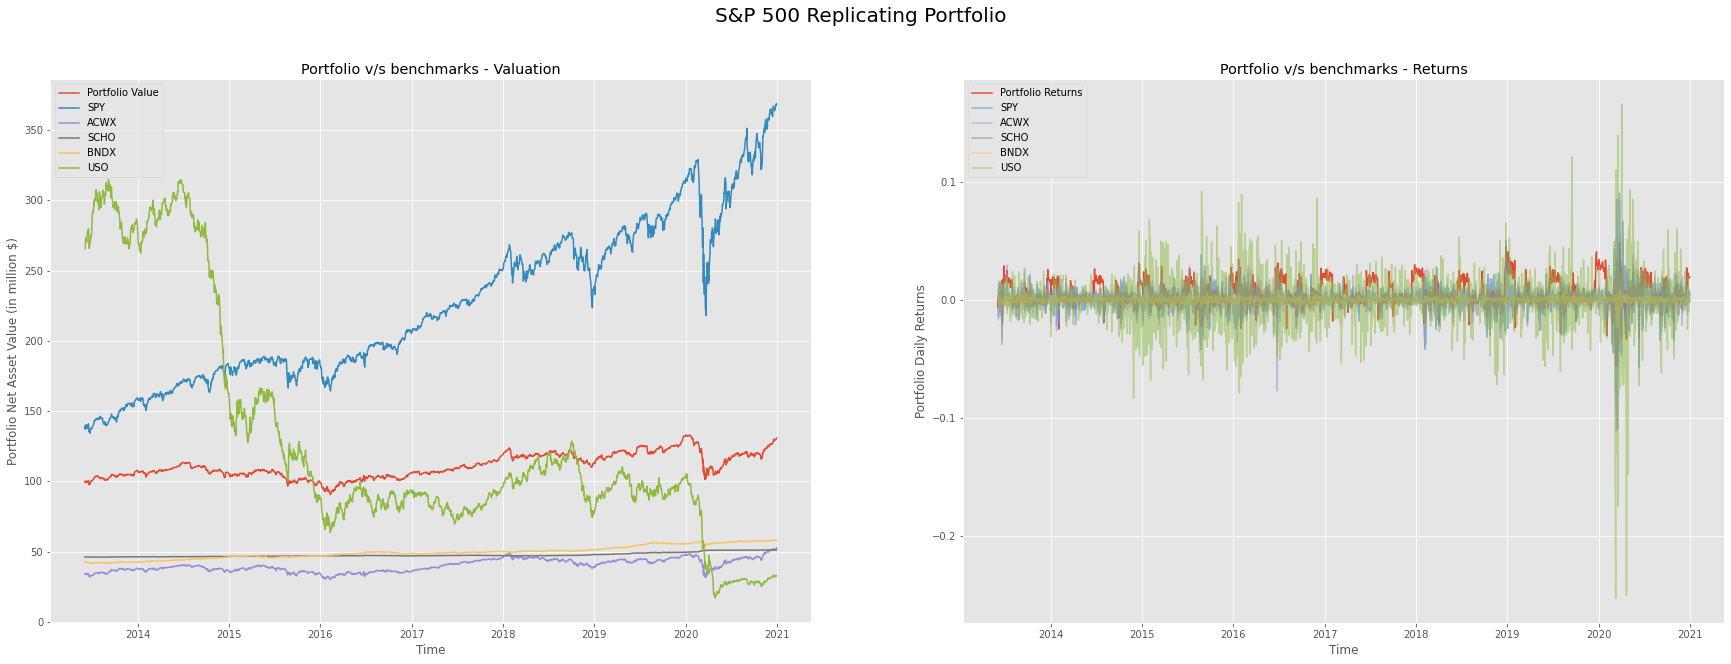

In [ ]:
fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
fig.set_size_inches(30, 10,  forward=True)

ax[0].plot(benchmark_val, label = ["Benchmark"])
ax[1].plot(benchmark_returns, label = ["Benchmark"])

for tic in portfolio_tickers:
    ax[0].plot(stock_data[("close",tic)], label = tic)
    ax[1].plot(stock_data[("close", tic)].pct_change(), alpha = 0.5, label = tic)


ax[0].set_xlabel("Time")
ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
ax[0].set_title("Portfolio v/s benchmarks - Valuation")

ax[1].set_xlabel("Time")
ax[1].set_ylabel("Portfolio Daily Returns")
ax[1].set_title("Portfolio v/s benchmarks - Returns")

ax[0].legend(["Portfolio Value"]+ portfolio_tickers)
ax[1].legend(["Portfolio Returns"]+ portfolio_tickers)

fig.suptitle('S&P 500 Replicating Portfolio',fontsize=20);

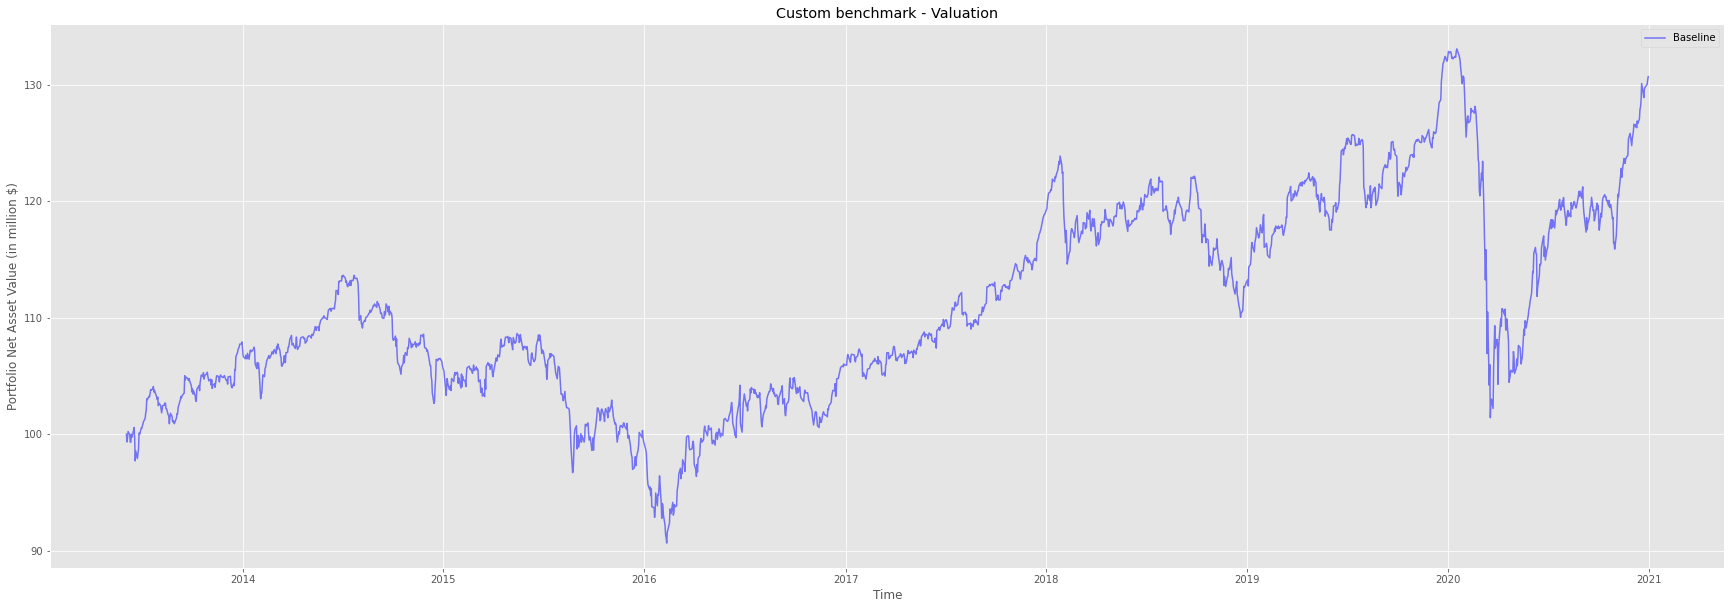

In [ ]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(benchmark_val, color = "blue", alpha = 0.5, label = benchmark_portfolio.target)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("Custom benchmark - Valuation")
plt.show()

# Efficient Portfolio

In [ ]:
capm_portfolio = Portfolio(target="Efficient Portfolio",
                        tickerset= ticker_set, investment= 100,
                        trading_algo= "capm_Algo",
                        rebalance=3, reconstitute=100)

capm_portfolio.echo()

Target Index: Efficient Portfolio
Trading Algorithm: CAPM Weights
Starting Investment: 100
Current Investment: 100


In [ ]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for date in stock_data.index:
    tmpdf = stock_data.loc[date]
    tmpdf = tmpdf.unstack().T
    valuation, returns =  capm_portfolio.run(date= date, price= tmpdf, tickerlist = portfolio_tickers)
    if (valuation, returns) == (-1,-1):
        print(portfolio_val.index[-1],date.date(), valuation, returns)
        continue
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns
portfolio_val.head()

Reconstitution on: 04-Jun-2013
	Rebalancing on: 04-Jun-2013
Index(['ACWX', 'BNDX', 'SCHO', 'SPY', 'USO'], dtype='object')
	Rebalancing on: 01-Aug-2013
Index(['ACWX', 'BNDX', 'SCHO', 'SPY', 'USO'], dtype='object')
	Rebalancing on: 01-Oct-2013
Index(['ACWX', 'BNDX', 'SCHO', 'SPY', 'USO'], dtype='object')
	Rebalancing on: 02-Dec-2013
Index(['ACWX', 'BNDX', 'SCHO', 'SPY', 'USO'], dtype='object')
	Rebalancing on: 03-Feb-2014
Index(['ACWX', 'BNDX', 'SCHO', 'SPY', 'USO'], dtype='object')
	Rebalancing on: 01-Apr-2014
Index(['ACWX', 'BNDX', 'SCHO', 'SPY', 'USO'], dtype='object')
	Rebalancing on: 02-Jun-2014
Index(['ACWX', 'BNDX', 'SCHO', 'SPY', 'USO'], dtype='object')
	Rebalancing on: 01-Aug-2014
Index(['ACWX', 'BNDX', 'SCHO', 'SPY', 'USO'], dtype='object')
	Rebalancing on: 01-Oct-2014
Index(['ACWX', 'BNDX', 'SCHO', 'SPY', 'USO'], dtype='object')
	Rebalancing on: 01-Dec-2014
Index(['ACWX', 'BNDX', 'SCHO', 'SPY', 'USO'], dtype='object')
	Rebalancing on: 02-Feb-2015
Index(['ACWX', 'BNDX', 'SCHO',

2013-06-04    100.000000
2013-06-05     99.717931
2013-06-06     99.903583
2013-06-07    100.127987
2013-06-10    100.111932
dtype: float64

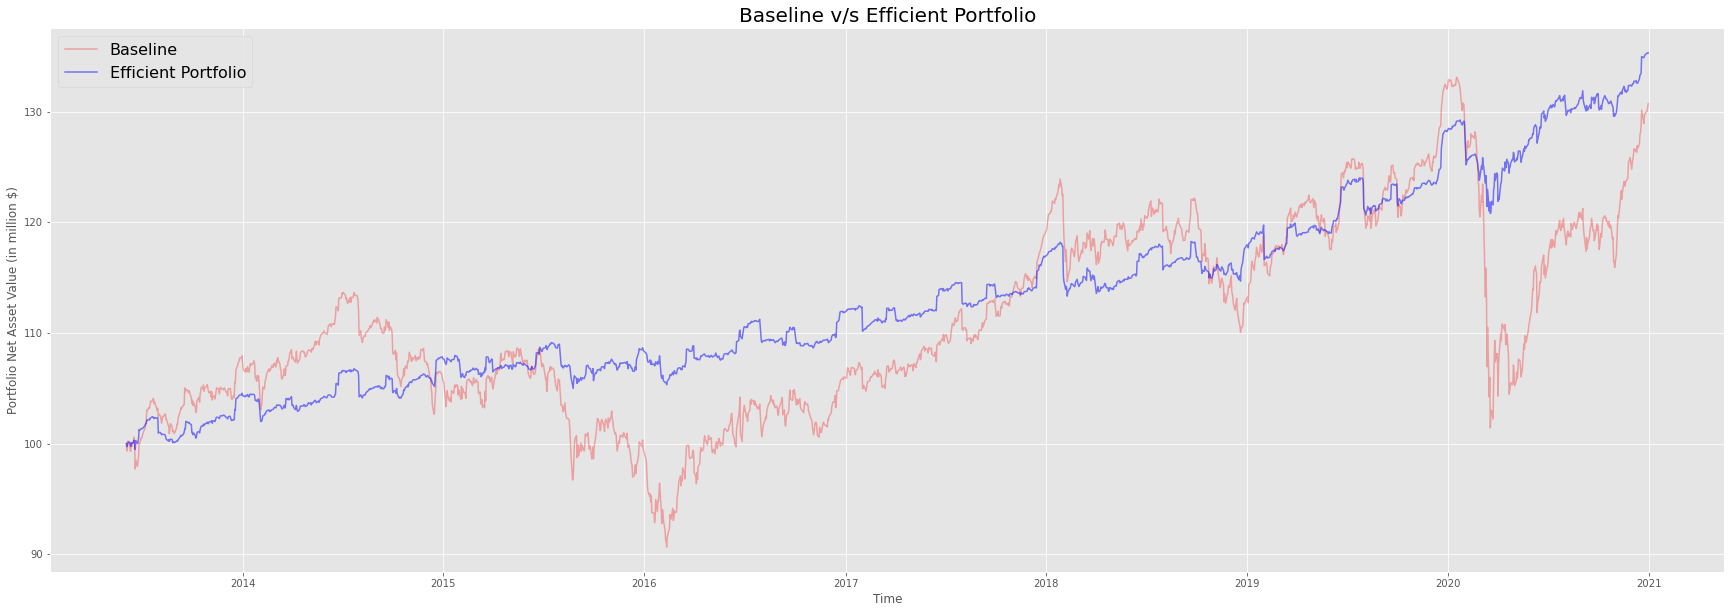

In [ ]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(benchmark_val, color = "red", alpha = 0.3, label = benchmark_portfolio.target)
plt.plot(portfolio_val, color = "blue", alpha = 0.5, label = capm_portfolio.target)
plt.legend(fontsize = 16)
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("Baseline v/s Efficient Portfolio", fontsize = 20)
plt.show()

# S&P500 Portfolio

## Read S&P 500 Index Constituent Data

- WRDS Method _(includes historical data)_

In [ ]:
spy_ticker_data = pd.read_csv("./data/sp500_constituents.csv")
spy_ticker_set = set(spy_ticker_data["Symbol"])
print("Unique Indices:",len(spy_ticker_set))
spy_ticker = dict()
for year in spy_ticker_data["Year"].unique():
    spy_ticker[year] = list(spy_ticker_data[spy_ticker_data["Year"] == year]["Symbol"])
# spy_ticker

FileNotFoundError: [Errno 2] No such file or directory: './data/sp500_constituents.csv'

Fetch data from WRDS using the  list

***

## Read Daily Stock data from WRDS


### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [ ]:
spy_dataframe = data[data["datadate"] >= pd.to_datetime("01-01-2010")]

# Temporay measure b/c our spy_ticker does not have 2021 data
spy_dataframe = data[data["datadate"] <= pd.to_datetime("01-01-2021")]
print("Number of unique tickers:",len(spy_dataframe.tic.value_counts()))
spy_data = spy_dataframe[["datadate","tic","div","shares","close"]].reset_index(drop=True)
print("Dimensions: ",spy_data.shape)
print(spy_data.isna().sum())
spy_data[np.isnan(spy_data.close)]

Number of unique tickers: 1190
Dimensions:  (2183146, 5)
datadate        0
tic             0
div             0
shares      49497
close         553
dtype: int64


,datadate,tic,div,shares,close
5592,2010-01-13,Z.1,0.1546,NaN,NaN
8973,2010-01-20,RRD.2,0.2721,NaN,NaN
12443,2010-01-27,5050B,0.1950,NaN,NaN
20504,2010-02-10,0051B,0.1250,NaN,NaN
20505,2010-02-10,0050B,0.0730,NaN,NaN
...,...,...,...,...,...
2141545,2020-10-15,Z.1,0.1983,NaN,NaN
2142940,2020-10-16,PLP.Z,0.5671,NaN,NaN
2165919,2020-11-30,6525B,0.4005,NaN,NaN
2173465,2020-12-14,AHC.2,0.3187,NaN,NaN


**Removing 29 Oct 2012 b/c everything is NaN. so portfolio becomes Nan**

Just a couple of Nan values in close.
Should not affect quaterly averages.

In [ ]:
spy_data.drop(index = spy_data[spy_data.close.isna()].index, inplace=True)
print(spy_data.isna().sum())

datadate        0
tic             0
div             0
shares      48944
close           0
dtype: int64


In [ ]:
spy_data = spy_data.set_index(["datadate","tic"])
spy_data

div        shares   close
datadate   tic                              
2010-01-04 AAMRQ   0.0  3.324560e+08    7.72
           MRO     0.0  7.078450e+08   32.11
           PCS     0.0  3.524010e+08    7.97
           LOW     0.0  1.472032e+09   23.16
           GOOGL   0.0  2.429990e+08  626.75
...                ...           ...     ...
2020-12-31 EXR     0.0  1.292350e+08  115.86
           AON     0.0  2.286160e+08  211.27
           BAC.PM  0.0  5.590000e+07   27.31
           MSI     0.0  1.695230e+08  170.06
           L       0.0  2.748730e+08   45.02

[2182593 rows x 3 columns]

In [ ]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],spy_data.index.values))))
market_calendar_dates[0:5]

[Timestamp('2010-01-04 00:00:00'),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2010-01-06 00:00:00'),
 Timestamp('2010-01-07 00:00:00'),
 Timestamp('2010-01-08 00:00:00')]

## Executing Portfolio

In [ ]:
;
%run -i 'portfolio.py'

<Figure size 432x288 with 0 Axes>

In [ ]:
# spy_trading_algo = SNP500_Algo("S&P 500 Algo")
spy_portfolio = Portfolio(target="S&P 500",
                        tickerset= [], investment= 1000000,
                        trading_algo= "SNP500_Algo",
                        rebalance=4, reconstitute=12)

spy_portfolio.echo()

Target Index: S&P 500


AttributeError: type object 'SNP500_Algo' has no attribute 'identifier'

In [ ]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for date in market_calendar_dates:
    tmpdf = spy_data.loc[date,:]
    valuation, returns =  spy_portfolio.run(date= date, price= tmpdf, tickerlist = spy_ticker[date.year])
    if (valuation, returns) == (-1,-1):
        print(portfolio_val.index[-1],date.date(), valuation, returns)
        continue
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns

Reconstitution on: 04-Jan-2010
	Rebalancing on: 04-Jan-2010
	Rebalancing on: 05-Jan-2010
	Rebalancing on: 06-Jan-2010
	Rebalancing on: 07-Jan-2010
	Rebalancing on: 08-Jan-2010
	Rebalancing on: 11-Jan-2010
	Rebalancing on: 12-Jan-2010
	Rebalancing on: 13-Jan-2010
	Rebalancing on: 14-Jan-2010
	Rebalancing on: 15-Jan-2010
	Rebalancing on: 19-Jan-2010
	Rebalancing on: 20-Jan-2010
	Rebalancing on: 21-Jan-2010
	Rebalancing on: 22-Jan-2010


<string>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Rebalancing on: 25-Jan-2010
	Rebalancing on: 26-Jan-2010
	Rebalancing on: 27-Jan-2010
	Rebalancing on: 28-Jan-2010
	Rebalancing on: 29-Jan-2010
	Rebalancing on: 01-Feb-2010
	Rebalancing on: 02-Feb-2010
	Rebalancing on: 03-Feb-2010
	Rebalancing on: 04-Feb-2010
	Rebalancing on: 05-Feb-2010
	Rebalancing on: 08-Feb-2010
	Rebalancing on: 09-Feb-2010
	Rebalancing on: 10-Feb-2010
	Rebalancing on: 11-Feb-2010
	Rebalancing on: 12-Feb-2010
	Rebalancing on: 16-Feb-2010
	Rebalancing on: 17-Feb-2010
	Rebalancing on: 18-Feb-2010
	Rebalancing on: 19-Feb-2010
	Rebalancing on: 22-Feb-2010
	Rebalancing on: 23-Feb-2010
	Rebalancing on: 24-Feb-2010
	Rebalancing on: 25-Feb-2010
	Rebalancing on: 26-Feb-2010
	Rebalancing on: 01-Mar-2010
	Rebalancing on: 02-Mar-2010
	Rebalancing on: 03-Mar-2010
	Rebalancing on: 04-Mar-2010
	Rebalancing on: 05-Mar-2010
	Rebalancing on: 08-Mar-2010
	Rebalancing on: 09-Mar-2010
	Rebalancing on: 10-Mar-2010
	Rebalancing on: 11-Mar-2010
	Rebalancing on: 12-Mar-2010
	Rebalancing o

In [ ]:
spy_portfolio.echo()
# print("Net return since start: ",spy_portfolio.net_return()*100,"%")

Target Index: S&P 500
Trading Algorithm: S&P 500 Algo
Starting Investment: 1000000
Current Investment: 3081413.6985582802
Constituent Indices: MMM, ABT, ABBV, ABMD, ACN ...
Constituent Weights: tic
JKHY     7.093611
ALL     28.263277
WRB     16.565733
FISV    62.317556
HON     65.222074
dtype: float64


In [ ]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns.fillna(1)+1)-1)*100,"%")

daily return:  0.0389266495835372 %


## S&P Index, ETF and Mutual Fund

In [ ]:
benchmark_data = yf.download("^GSPC SPY VFIAX", start="2010-01-01", end="2020-12-31")
benchmark_data = benchmark_data["Close"]#.loc[portfolio_returns.index]
benchmark_data.head()

[*********************100%***********************]  3 of 3 completed


,SPY,VFIAX,^GSPC
Date,,,
2010-01-04,113.330002,104.320000,1132.989990
2010-01-05,113.629997,104.650002,1136.520020
2010-01-06,113.709999,104.750000,1137.140015
2010-01-07,114.190002,105.180000,1141.689941
2010-01-08,114.570000,105.480003,1144.979980


In [ ]:
baseline_return = benchmark_data.apply(daily_returns).fillna(0)
baseline_return.head()

,SPY,VFIAX,^GSPC
Date,,,
2010-01-04,0.000000,0.000000,0.000000
2010-01-05,0.002647,0.003163,0.003116
2010-01-06,0.000704,0.000956,0.000546
2010-01-07,0.004221,0.004105,0.004001
2010-01-08,0.003328,0.002852,0.002882


## Plot

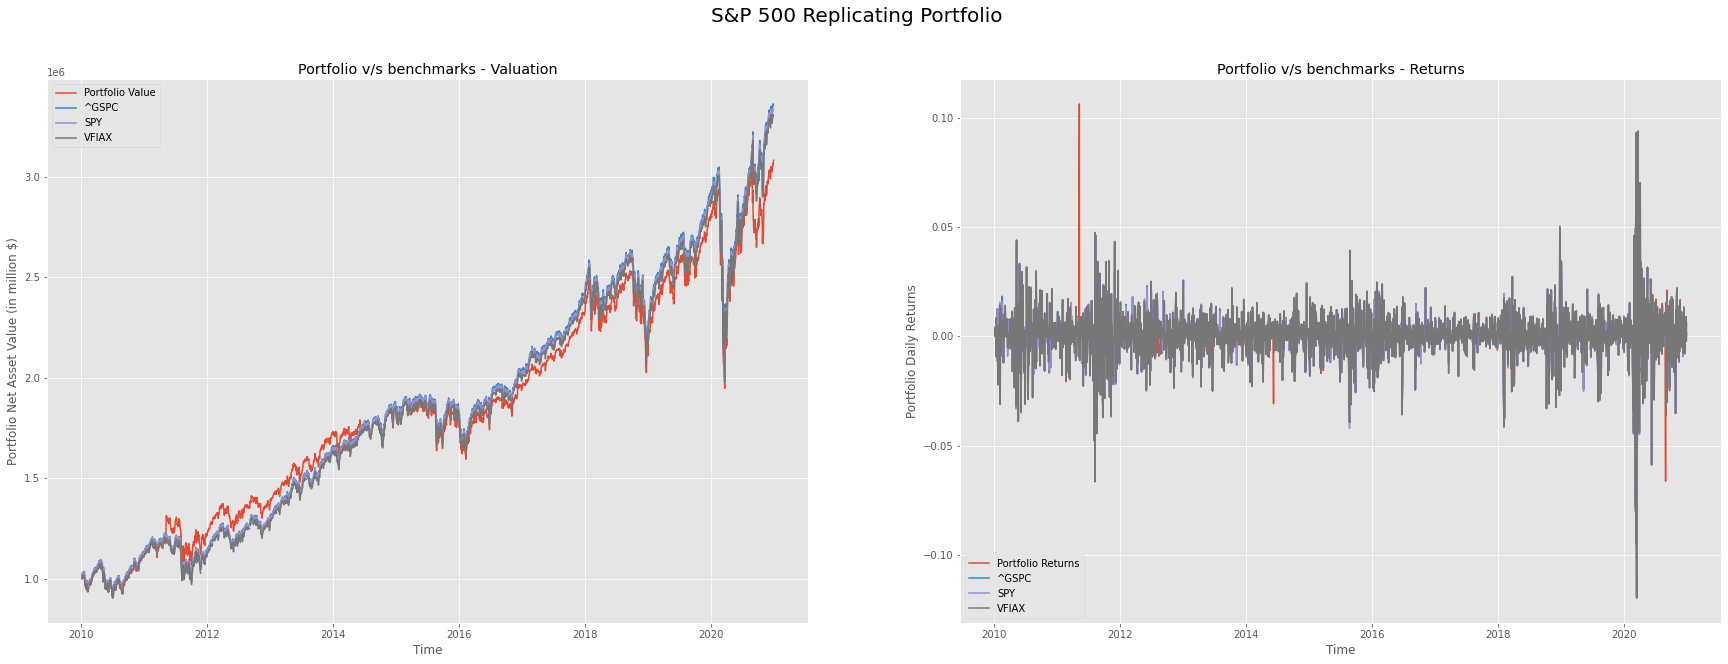

In [ ]:
fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
fig.set_size_inches(30, 10,  forward=True)

ax[0].plot(portfolio_val)
ax[0].plot(benchmark_data["^GSPC"]*900)
ax[0].plot(benchmark_data["SPY"]*8961.3)
ax[0].plot(benchmark_data["VFIAX"]*9600)
ax[0].legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
ax[0].set_title("Portfolio v/s benchmarks - Valuation")

ax[1].plot(portfolio_returns)
ax[1].plot(baseline_return["^GSPC"])
ax[1].plot(baseline_return["SPY"])
ax[1].plot(baseline_return["VFIAX"])
ax[1].legend(["Portfolio Returns","^GSPC","SPY","VFIAX"])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Portfolio Daily Returns")
ax[1].set_title("Portfolio v/s benchmarks - Returns")

fig.suptitle('S&P 500 Replicating Portfolio',fontsize=20);

In [ ]:
tracking_error_spy = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_spy.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

Tracking error between our portfolio and SPY is 0.267%
Tracking error between our portfolio and VFIAX is 0.328%
Tracking error between our portfolio and ^GSPC is 0.253%


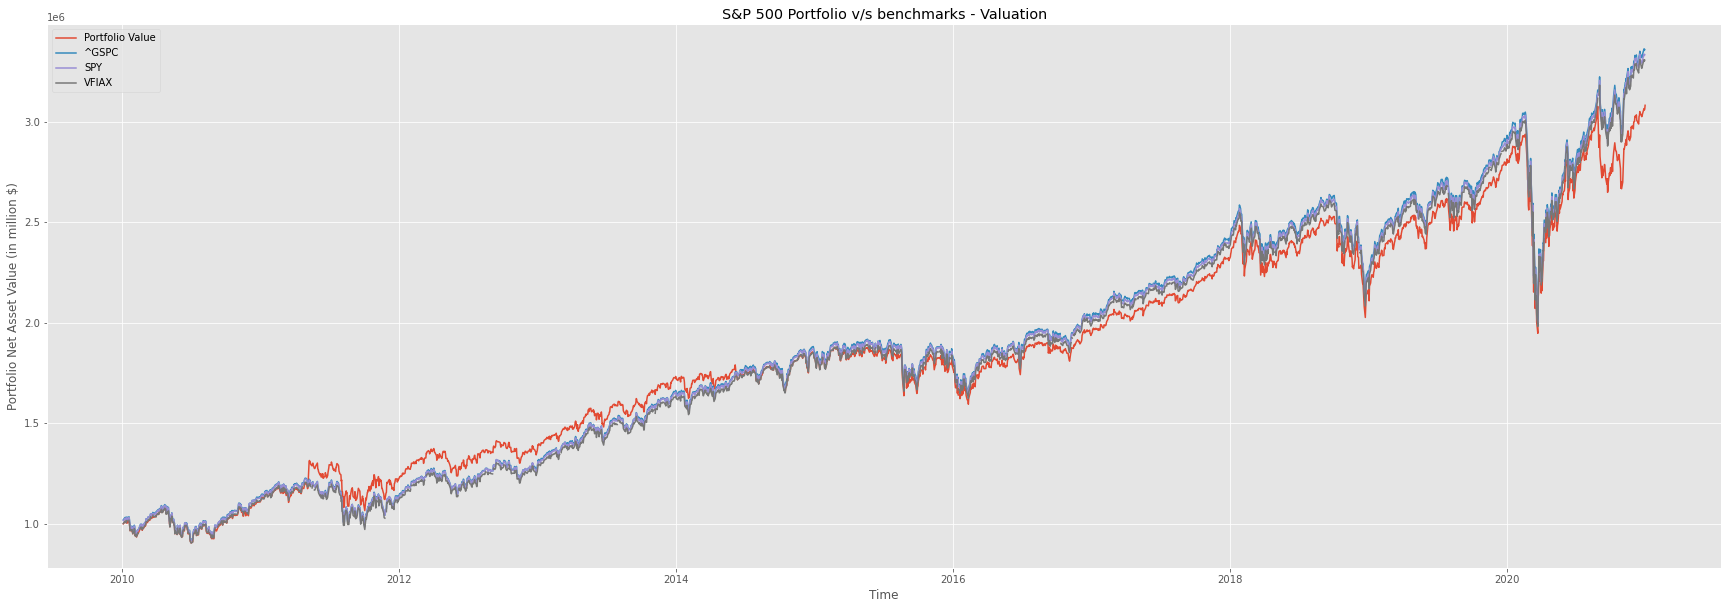

In [ ]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(portfolio_val)
plt.plot(benchmark_data["^GSPC"]*900)
plt.plot(benchmark_data["SPY"]*8961.3)
plt.plot(benchmark_data["VFIAX"]*9600)
plt.legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("S&P 500 Portfolio v/s benchmarks - Valuation")
plt.show()

***
***